## Imports and Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [76]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
import string
import os
import re
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier

In [77]:
!pip install pyLDAvis 

## Topic Modeling

### Data Loading

In [78]:
class DataLoader:
  def __init__(self,dir_name,file_name):
    self.dir_name = dir_name
    self.file_name = file_name
    
 
  def read_csv(self):
    os.chdir(self.dir_name)
    tweets_df=pd.read_csv(self.file_name)
    return tweets_df

In [79]:
#object creation
# The data has already been processed on the week0 task 1
DataLoader_obj = DataLoader('/content/drive/MyDrive/','processed_and_cleaned_tweet_data_full.csv')

In [80]:
tweets_df=DataLoader_obj.read_csv()
tweets_df.dropna()

,created_at,source,original_text,polarity,subjectivity,lang,fav_count,retweet_count,screen_name,follower_count,friends_count,sensitivity,hashtags,mentions,location,cleaned_text,polarity_cleaned,subjectivity_cleaned


In [81]:
tweets_df.head()

,created_at,source,original_text,polarity,subjectivity,lang,fav_count,retweet_count,screen_name,follower_count,friends_count,sensitivity,hashtags,mentions,location,cleaned_text,polarity_cleaned,subjectivity_cleaned
0,Sun Aug 07 22:31:20 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,-1.250000e-01,0.190625,en,0,2,i_ameztoy,20497,2621,False,"[{'text': 'City', 'indices': [132, 137]}]","[{'screen_name': 'i_ameztoy', 'name': 'Iban Am...",NaN,Extra random image (I)Lets focus in one very...,-1.250000e-01,0.190625
1,Sun Aug 07 22:31:16 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,-1.000000e-01,0.100000,en,0,201,ZIisq,65,272,False,"[{'text': 'China', 'indices': [18, 24]}, {'tex...","[{'screen_name': 'IndoPac_Info', 'name': 'Indo...",NaN,China's media explains the military reasons ...,-1.000000e-01,0.100000
2,Sun Aug 07 22:31:07 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",0.000000e+00,0.000000,en,0,0,Fin21Free,85,392,False,"[{'text': 'XiJinping', 'indices': [127, 137]}]","[{'screen_name': 'ZelenskyyUa', 'name': 'Волод...",NaN,"China even cut off communication, they don't a...",0.000000e+00,0.000000
3,Sun Aug 07 22:31:06 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",1.000000e-01,0.350000,en,0,0,Fin21Free,85,392,False,"[{'text': 'XiJinping', 'indices': [9, 19]}]",[],NaN,"Putin to XiJinping I told you my friend, Taiw...",1.000000e-01,0.350000
4,Sun Aug 07 22:31:04 +0000 2022,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",-6.938894e-18,0.556250,en,0,381,VizziniDolores,910,2608,False,[],"[{'screen_name': 'ChinaUncensored', 'name': 'C...",NaN,"I’m sorry, I thought Taiwan was an independe...",-6.938894e-18,0.556250


In [82]:
tweets_df.columns

Index(['created_at', 'source', 'original_text', 'polarity', 'subjectivity',
       'lang', 'fav_count', 'retweet_count', 'screen_name', 'follower_count',
       'friends_count', 'sensitivity', 'hashtags', 'mentions', 'location',
       'cleaned_text', 'polarity_cleaned', 'subjectivity_cleaned'],
      dtype='object')

### Data preparing

In [83]:
class PrepareData:
  def __init__(self,df):
    self.df=df
    
  def preprocess_data(self):
    tweets_df = self.df.loc[self.df['lang'] =="en"]

    
    #text Preprocessing
    tweets_df['cleaned_text'] = tweets_df['cleaned_text'].astype(str)
    tweets_df['cleaned_text'] = tweets_df['cleaned_text'].apply(lambda x: x.lower())
    tweets_df['cleaned_text'] = tweets_df['cleaned_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
    
    #Converting tweets to list of words For feature engineering
    sentence_list = [tweet for tweet in tweets_df['cleaned_text']]
    word_list = [sent.split() for sent in sentence_list]
    # print(word_list)

    #Create dictionary which contains Id and word 
    word_to_id = corpora.Dictionary(word_list) #generate unique tokens
    #  we can see the word to unique integer mapping
    # print(word_to_id.token2id)
    # using bag of words(bow), we create a corpus that contains the word id and its frequency in each document.
    corpus_1= [word_to_id.doc2bow(tweet) for tweet in word_list]


    return word_list, word_to_id, corpus_1


In [84]:
PrepareData_obj=PrepareData(tweets_df)
word_list, id2word, corpus = PrepareData_obj.preprocess_data()

In [85]:
print(word_list[::10])
print(corpus[::190])

[['extra', 'random', 'image', 'ilets', 'focus', 'in', 'one', 'very', 'specific', 'zone', 'of', 'the', 'western', 'coast', 'gt', 'longjing', 'district', 'taichung', 'city', 'ta…'], ['latest', 'when', 'the', 'pla', 'conducted', 'massive', 'drills', 'around', 'taiwan', 'in', 'response', 'to', 'the', 'serious', 'provocations', 'made', 'by', 'the', 'us', 'on…'], ['🚨🇨🇳🇹🇼china', 'now', 'has', 'taiwan', 'surrounded', 'from', 'air', 'and', 'the', 'sea', 'as', 'it', 'gears', 'up', 'to', 'start', 'the', 'next', 'round', 'of', 'military', 'drill', 'exer…'], ['chinas', 'media', 'explains', 'the', 'military', 'reasons', 'for', 'each', 'area', 'of', 'the', 'drills', 'in', 'the', 'taiwan', 'strait', 'its', 'clear', 'the', 'drills', 'ar…'], ['nancy', 'pelosi', 'is', 'willing', 'to', 'risk', 'starting', 'a', 'war', 'with', 'china', 'so', 'that', 'she', 'can', 'make', 'massive', 'profits', 'on', 'her', 'husbands', 'inside…'], ['a', 'chinese', 'official', 'said', 'in', 'a', 'statement', 'to', 'state', 'tv

### LDA Topic Modeling

In [86]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.show_topics(formatted=False))

### Model Analysis

In [88]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -7.5475529941612045

 Ldamodel Coherence Score/Accuracy on Tweets:  0.2522441509798848


### Analysing Results

In [89]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.170881  0.042272       1        1  30.751915
3      0.105192 -0.041489       2        1  21.179062
2      0.117601  0.115866       3        1  21.117753
0     -0.108803 -0.282366       4        1  16.308988
1     -0.284870  0.165716       5        1  10.642282, topic_info=        Term         Freq         Total Category  logprob  loglift
55         a  5623.000000   5623.000000  Default  30.0000  30.0000
106       on  6119.000000   6119.000000  Default  29.0000  29.0000
116       is  5450.000000   5450.000000  Default  28.0000  28.0000
78        an  1902.000000   1902.000000  Default  27.0000  27.0000
176  missile  1772.000000   1772.000000  Default  26.0000  26.0000
..       ...          ...           ...      ...      ...      ...
10        of  1289.624439   8823.284761   Topic5  -3.5376   0.3173
32    taiwan   729.319039  14167.622136   Topic5  -4.1076  -0.7263
52        to   658.314962  10114.689853   Topic5  -4.2100  -0.4917
16       the   573.006406  16351.162007   Topic5  -4.3488  -1.1108
112      and   262.211788   5578.000098   Topic5  -5.1305  -0.8171

[276 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
715        4  0.996104                    23
269        4  0.998491                     3
4493       3  0.998052                   4th
171        3  0.997961  4thchinataiwancrisis
55         1  0.197575                     a
...      ...       ...                   ...
535        2  0.998646                  your
607        5  0.998713                    🇹🇼
16238      4  0.012697                     🎁
16238      5  0.984022                     🎁
7746       5  0.998820                     🤗

[293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 1, 2])

## Sentiment Analysis 

### Data Loading

In [90]:
# Read the Data
DataLoader_obj = DataLoader('/content/drive/MyDrive/','processed_and_cleaned_tweet_data_full.csv')

### Basic EDA

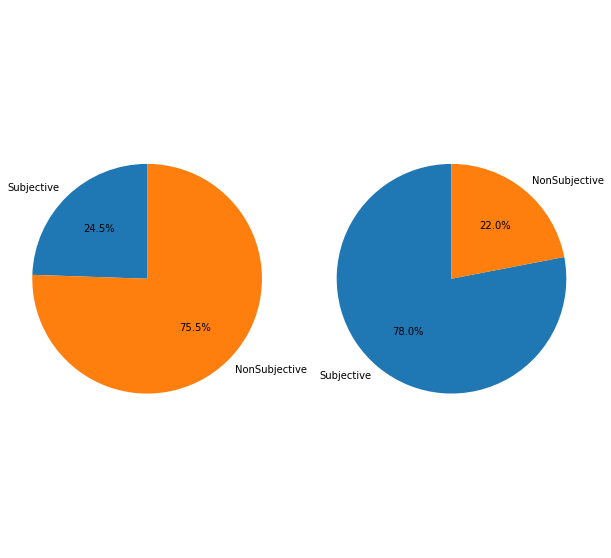

In [91]:
# Visualizing the polarity and subjectivity of tweets separately
labels_sub = 'Subjective', 'NonSubjective'
labels_polar = 'Polar', 'NonPolar'
sizes_sub = [len(tweets_df[tweets_df['subjectivity'] >= .5]), len(tweets_df[tweets_df['subjectivity'] < .5])]
sizes_polar = [len(tweets_df[tweets_df['polarity'] >= 0]), len(tweets_df[tweets_df['polarity'] < 0])]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.pie(sizes_sub, labels=labels_sub, autopct='%1.1f%%', startangle=90)
ax2.pie(sizes_polar, labels=labels_sub, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
ax2.axis('equal')  
plt.show()

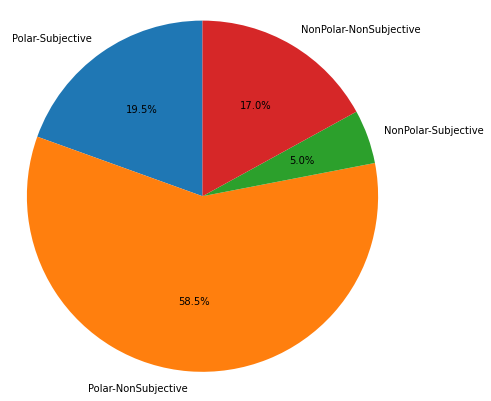

In [92]:
# Visualizing the polarity and subjectivity of tweets together
## Polar-Subjective, Polar-NonSubjective, NonPolar-Subjective, NonPolar-Non-Subjective
labels = 'Polar-Subjective', 'Polar-NonSubjective', 'NonPolar-Subjective', 'NonPolar-NonSubjective'
sizes = [
          len(tweets_df[(tweets_df['polarity'] >= 0) & (tweets_df['subjectivity'] >= .5)]), 
          len(tweets_df[(tweets_df['polarity'] >= 0) & (tweets_df['subjectivity'] < .5)]),
          len(tweets_df[(tweets_df['polarity'] < 0) & (tweets_df['subjectivity'] >= .5)]), 
          len(tweets_df[(tweets_df['polarity'] < 0) & (tweets_df['subjectivity'] < .5)]),
        ]
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.show()

### Data Cleaning

In [93]:
tweets_df['polarity'] = (tweets_df['polarity'] >= 0).astype(int)
tweets_df['subjectivity'] = (tweets_df['subjectivity'] >= 0.5).astype(int)

In [99]:
tweets_df['subjectivity']

0        0
1        0
2        0
3        0
4        1
        ..
21995    1
21996    1
21997    0
21998    0
21999    0
Name: subjectivity, Length: 22000, dtype: int64

In [95]:
# Selecting the feature and the label
features = tweets_df.iloc[:, 15].values
label1 = tweets_df.iloc[:, 3].values
label2 = tweets_df.iloc[:, 4].values

In [96]:
# Data Cleaning using regular expression
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

### Representing Text in Numeric Form

In [97]:
nltk.download('stopwords')

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features_vectorized = vectorizer.fit_transform(processed_features).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Split and Train Data

In [100]:
X_train_pol, X_test_pol, y_train_pol, y_test_pol = train_test_split(processed_features_vectorized, label1, test_size=0.2, random_state=42)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(processed_features_vectorized, label2, test_size=0.2, random_state=42)

text_classifier_polarity = RandomForestClassifier(n_estimators=100, random_state=42)
text_classifier_subjectivity = RandomForestClassifier(n_estimators=100, random_state=42)

text_classifier_polarity.fit(X_train_pol, y_train_pol)
text_classifier_subjectivity.fit(X_train_sub, y_train_sub)

RandomForestClassifier(random_state=0)

### Prediction

In [101]:
prediciton_pol = text_classifier_polarity.predict(X_test_pol)
prediction_sub = text_classifier_subjectivity.predict(X_test_sub)

### Evaluation

In [102]:
from sklearn.metrics import accuracy_score

print("Accuracy of Polarity", accuracy_score(y_test_pol, prediciton_pol))
print("Accuracy of Subjectivity", accuracy_score(y_test_sub, prediction_sub))

Accuracy of Polarity 0.9572727272727273
Accuracy of Subjectivity 0.9481818181818182
